- File name : GAN.ipynb
- Written by Dongwon Kim
- GAN
    - build a GAN model with MNIST dataset
- Modificatoin history
    - modify by Dongwon Kim on Nov 11, 2021
        - on given backbone code, 
        - transform dataset
        - Generator, Discriminator model structure
        - set models, optimizers, and a loss function
        - print loss value for each 5 epochs
- reference
    https://paperswithcode.com/method/gan

In [ ]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from datetime import timedelta
from multiprocessing import cpu_count
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

# Setting
- set random fake_z for initial input for generator
- set SEED as 42 to let compare result easily

In [ ]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

GPU = 0

device = torch.device(f'cuda:{GPU}' if torch.cuda.is_available() else 'cpu')

# make random initial input for generator
def fake_z(batch_size, noise, device):
    return torch.randn(batch_size, noise, device=device)

# Dataset
- get MNIST dataset from torchvision.datasets
- transform the data

In [ ]:
transform = transforms.Compose([
# Transform data
    transforms.ToTensor(),         # to tensor, range 0 ~ 1
    transforms.Normalize(0.5, 0.5) # change range to -1 ~ 1
])

# get dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

- set number of workers
- get dataset using dataloader

In [ ]:
BATCH_SIZE = 128

if cpu_count() > 5:
    NUM_WORKERS = cpu_count() // 2
elif cpu_count() < 2:
    NUM_WORKERS = 0
else:
    NUM_WORKERS = 2
    
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Model

## Generator
- set noise, hidden referencing given code
- size: size of input, final output of generator will size * size
    - (for MNIST, 28 * 28)
- a: slope gradient for LeakyReLU, default = 0.01
- droprate: droprate for Dropout, default = 0.1(referencing given code) 
- noise -> hidden -> hidden -> input size -> (tanh)
- use LeakyReLU to avoid gradient vanishing problem
---
- try to make output becomes 1(1 means real)
    - since generator make fake image and want to cheat discriminator
- on the other hand, discriminator tries to make output becomes 0(0 means fake)
    - since discriminator want to find out that the input is fake

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise=100, hidden=256, size=28, a=0.01, droprate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(noise, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, size * size)
        self.relu = nn.LeakyReLU(a)
        self.dropout = nn.Dropout(p=droprate)
    def forward(self, x):
        output = x
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.fc2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc3(output)
        output = torch.tanh(output)
        return output

## Discriminator
- hidden, size, a, droprate are also set as default
- input size -> hidden -> hidden -> 1 -> (sigmoid)
- use BCELoss as loss function, need sigmoid


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, hidden=256, size=28, a=0.01, droprate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(size * size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.relu = nn.LeakyReLU(a)
        self.dropout = nn.Dropout(p=droprate)

    def forward(self, x):
        output = x
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc3(output)
        output = torch.sigmoid(output)
        return output

# Train and Evaluate

## Set parameters, models, optimizers and loss function

In [ ]:
noise = 100
learning_rate = 0.0001

generator = Generator()
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)

# use differenct optimizer to train models independently
gen_op = optim.Adam(generator.parameters(), lr = learning_rate)
dis_op = optim.Adam(discriminator.parameters(), lr = learning_rate)

criterion = nn.BCELoss()
criterion = criterion.to(device)

Epoch [5/200] Gen Loss: 4.178421974182129 Dis Loss: 0.37125352025032043 Elapsed time: 0:00:44.499423
Epoch [10/200] Gen Loss: 4.1195268630981445 Dis Loss: 0.3226417899131775 Elapsed time: 0:01:29.420648
Epoch [15/200] Gen Loss: 3.1862380504608154 Dis Loss: 0.4551655352115631 Elapsed time: 0:02:13.888003
Epoch [20/200] Gen Loss: 3.473316192626953 Dis Loss: 0.3996773660182953 Elapsed time: 0:02:58.403154


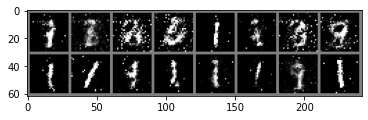

Epoch [25/200] Gen Loss: 2.59114408493042 Dis Loss: 0.5982964634895325 Elapsed time: 0:03:43.648082
Epoch [30/200] Gen Loss: 2.2057175636291504 Dis Loss: 0.8166751861572266 Elapsed time: 0:04:28.514205
Epoch [35/200] Gen Loss: 2.5673863887786865 Dis Loss: 0.5757369995117188 Elapsed time: 0:05:13.177748
Epoch [40/200] Gen Loss: 2.2390329837799072 Dis Loss: 0.5712588429450989 Elapsed time: 0:05:57.777893


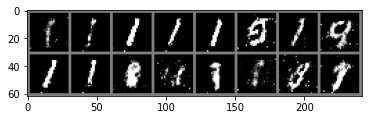

Epoch [45/200] Gen Loss: 2.110471725463867 Dis Loss: 0.5630556344985962 Elapsed time: 0:06:42.869784
Epoch [50/200] Gen Loss: 2.55182147026062 Dis Loss: 0.43997594714164734 Elapsed time: 0:07:27.728794
Epoch [55/200] Gen Loss: 1.933397650718689 Dis Loss: 1.0372008085250854 Elapsed time: 0:08:13.115298
Epoch [60/200] Gen Loss: 2.0631346702575684 Dis Loss: 0.6547503471374512 Elapsed time: 0:08:57.929572


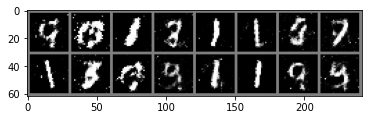

Epoch [65/200] Gen Loss: 1.7842979431152344 Dis Loss: 0.6320285797119141 Elapsed time: 0:09:43.187512
Epoch [70/200] Gen Loss: 2.299896240234375 Dis Loss: 0.5269012451171875 Elapsed time: 0:10:28.077142
Epoch [75/200] Gen Loss: 1.7516530752182007 Dis Loss: 0.7579661011695862 Elapsed time: 0:11:13.263148
Epoch [80/200] Gen Loss: 2.1267356872558594 Dis Loss: 0.8068747520446777 Elapsed time: 0:11:57.499017


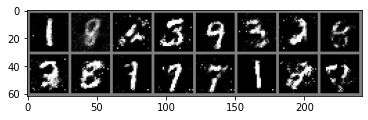

Epoch [85/200] Gen Loss: 1.6200361251831055 Dis Loss: 0.6564866304397583 Elapsed time: 0:12:42.148814
Epoch [90/200] Gen Loss: 1.6091288328170776 Dis Loss: 0.8393237590789795 Elapsed time: 0:13:27.276127
Epoch [95/200] Gen Loss: 1.8730806112289429 Dis Loss: 0.7305353283882141 Elapsed time: 0:14:12.212742
Epoch [100/200] Gen Loss: 1.5033071041107178 Dis Loss: 0.6983856558799744 Elapsed time: 0:14:56.850773


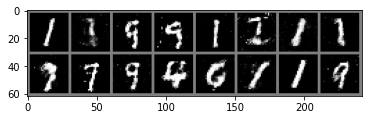

Epoch [105/200] Gen Loss: 1.5388579368591309 Dis Loss: 0.9445601105690002 Elapsed time: 0:15:41.696000
Epoch [110/200] Gen Loss: 1.4011752605438232 Dis Loss: 0.9398051500320435 Elapsed time: 0:16:26.586231
Epoch [115/200] Gen Loss: 1.2884694337844849 Dis Loss: 0.9372919797897339 Elapsed time: 0:17:11.519943
Epoch [120/200] Gen Loss: 1.3151676654815674 Dis Loss: 0.9025408029556274 Elapsed time: 0:17:56.016685


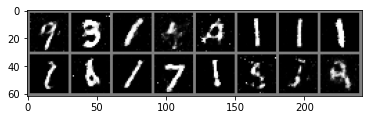

Epoch [125/200] Gen Loss: 1.5195186138153076 Dis Loss: 0.971185564994812 Elapsed time: 0:18:40.484004
Epoch [130/200] Gen Loss: 1.3812421560287476 Dis Loss: 1.0191172361373901 Elapsed time: 0:19:24.841677
Epoch [135/200] Gen Loss: 1.513809084892273 Dis Loss: 0.9815704822540283 Elapsed time: 0:20:09.294657
Epoch [140/200] Gen Loss: 1.1361126899719238 Dis Loss: 0.9859171509742737 Elapsed time: 0:20:53.581233


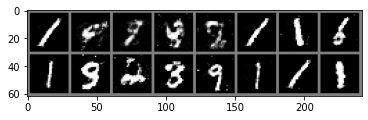

Epoch [145/200] Gen Loss: 1.410653829574585 Dis Loss: 0.8738234639167786 Elapsed time: 0:21:38.277287
Epoch [150/200] Gen Loss: 1.4583871364593506 Dis Loss: 0.9337813854217529 Elapsed time: 0:22:23.211789
Epoch [155/200] Gen Loss: 1.1818675994873047 Dis Loss: 1.0233731269836426 Elapsed time: 0:23:07.624526
Epoch [160/200] Gen Loss: 1.4521522521972656 Dis Loss: 0.8717656135559082 Elapsed time: 0:23:52.069678


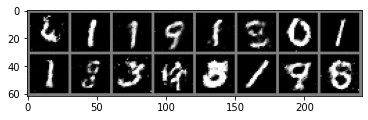

Epoch [165/200] Gen Loss: 1.3764804601669312 Dis Loss: 0.8625206351280212 Elapsed time: 0:24:36.516108
Epoch [170/200] Gen Loss: 1.1894887685775757 Dis Loss: 1.0151047706604004 Elapsed time: 0:25:21.175404
Epoch [175/200] Gen Loss: 1.3458421230316162 Dis Loss: 1.0961201190948486 Elapsed time: 0:26:06.303783
Epoch [180/200] Gen Loss: 1.4538987874984741 Dis Loss: 0.8691182136535645 Elapsed time: 0:26:51.162651


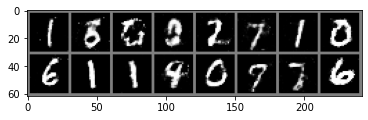

Epoch [185/200] Gen Loss: 1.2728863954544067 Dis Loss: 0.9426206350326538 Elapsed time: 0:27:36.011959
Epoch [190/200] Gen Loss: 1.1673150062561035 Dis Loss: 1.0458253622055054 Elapsed time: 0:28:20.509442
Epoch [195/200] Gen Loss: 1.326729655265808 Dis Loss: 1.0535300970077515 Elapsed time: 0:29:05.360710
Epoch [200/200] Gen Loss: 1.4917582273483276 Dis Loss: 0.9774978160858154 Elapsed time: 0:29:50.207118


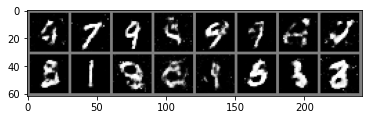

In [ ]:
EPOCHS = 200

start = time.time()

for ep in range(EPOCHS):

    generator.train()
    discriminator.train()

    for image, _ in trainloader:
        batch_size = image.size(0)

        image = image.to(device)
 
        real_label = torch.ones(batch_size).view(-1, 1).to(device)
        fake_label = torch.zeros(batch_size).view(-1, 1).to(device)

        dis_op.zero_grad()

        # discriminator check real image
        real_output = discriminator(image.view(-1, 28 * 28))
        # discriminator check fake image generated by generator
        fake_output = discriminator(generator(fake_z(batch_size, noise, device)))

        # since real_output is from real image, the value should be 1
        real_loss = criterion(real_output, real_label)
        # since fake_output is from generator, the value should be 0
        fake_loss = criterion(fake_output, fake_label)
        # combine two loss and train discriminator
        dis_loss = real_loss + fake_loss
  
        dis_loss.backward()
        dis_op.step()

        gen_op.zero_grad()

        # get checked result of fake image 
        fake_output = discriminator(generator(fake_z(batch_size, noise, device)))

        # generator want fake_output become 1(to cheat discriminator)  
        gen_loss = criterion(fake_output, real_label)

        # train generator  
        gen_loss.backward()
        gen_op.step()

    # Print loss, time spent every 5 epochs
    if (ep + 1) % 5 == 0:
        print('Epoch [{}/{}] Gen Loss: {} Dis Loss: {} Elapsed time: {}'.format(ep + 1, EPOCHS, gen_loss, dis_loss, timedelta(seconds=time.time() - start)))

    # Generate 16 images every 20 epochs
    if (ep + 1) % 20 == 0:
        discriminator.eval()
        generator.eval()

        with torch.no_grad():
            image = make_grid(generator(fake_z(16, noise, device)).view(-1, 1, 28, 28).detach().cpu())
            image = (image + 1) / 2
            image = image.numpy()
            image = np.transpose(image, (1, 2, 0))
            plt.imshow(image)
            plt.show()